# Mixed Programing

In this tutorial we show how to combine NDArray and Symbol together to train a neural network from scratch. This mixed programming flavor is one of the unique feature that make MXNet different to other frameworks. The `MX` term in MXNet also often means "mixed". 

## Training a Multi-layer Perception. 

We will use a two-layer perception as the example to show the idea. Note that the codes apply to other objective functions such as deep convolutional neural networks as well. We first define the network:

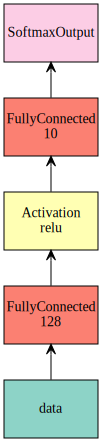

In [1]:
import mxnet as mx
num_classes = 10
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=num_classes)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net)

The free variables include the weight and the bias from each fully connected layer (`fc1` and `fc2`), the example for variable `data`, and the label for the softmax output `out`. We list all these variables' name by `list_argument`: 

In [2]:
print(net.list_arguments())

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']


To run forward and backward, we need to bind data to all free variables first. We can create all `NDArray`s and then bind them as we did on the [Symbol tutorial](./symbol.ipynb). There is also function named `simple_bind` that simplifies this procedure. This function first inferences the shapes of all free variables by using the provided data shape, and then allocate and bind data, which can be accessed by the attribute `arg_arrays` of the returned executor. 

In [9]:
num_features = 100
batch_size = 100
ex = net.simple_bind(ctx=mx.cpu(), data=(batch_size, num_features))
args = dict(zip(net.list_arguments(), ex.arg_arrays))
for name in args:
    print(name, args[name].shape)

('fc2_weight', (10L, 128L))
('fc1_weight', (128L, 100L))
('out_label', (100L,))
('fc2_bias', (10L,))
('data', (100L, 100L))
('fc1_bias', (128L,))


Change `ctx` to GPU we can let the arrays be allocated on GPU:

In [22]:
ex = net.simple_bind(ctx=mx.gpu(), data=(batch_size, num_features))
args = dict(zip(net.list_arguments(), ex.arg_arrays))
for name in args:
    print(name, args[name].shape, args[name].context)

('fc2_weight', (10L, 128L), gpu(0))
('fc1_weight', (128L, 100L), gpu(0))
('out_label', (100L,), gpu(0))
('fc2_bias', (10L,), gpu(0))
('data', (100L, 100L), gpu(0))
('fc1_bias', (128L,), gpu(0))


Then we initialize the weights by random values. 

In [23]:
for name in args:
    data = args[name]
    if 'weight' in name:
        data[:] = mx.random.uniform(-0.1, 0.1, data.shape)
    if 'bias' in name:
        data[:] = 0

Before training, we generate a synthetic dataset

In [11]:
import numpy as np
import matplotlib.pyplot as plt
class ToyData:
    def __init__(self, num_classes, num_features):
        self.num_classes = num_classes
        self.num_features = num_features
        self.mu = np.random.rand(num_classes, num_features)
        self.sigma = np.ones((num_classes, num_features)) * 0.1
    def get(self, num_samples):
        num_cls_samples = num_samples / self.num_classes
        x = np.zeros((num_samples, self.num_features))
        y = np.zeros((num_samples, ))
        for i in range(self.num_classes):
            cls_samples = np.random.normal(self.mu[i,:], self.sigma[i,:], (num_cls_samples, self.num_features))
            x[i*num_cls_samples:(i+1)*num_cls_samples] = cls_samples
            y[i*num_cls_samples:(i+1)*num_cls_samples] = i
        return x, y
    def plot(self, x, y):
        colors = ['r', 'b', 'g', 'c', 'y']
        for i in range(self.num_classes):
            cls_x = x[y == i]
            plt.scatter(cls_x[:,0], cls_x[:,1], color=colors[i%5], s=1)
        plt.show()

toy_data = ToyData(num_classes, num_features)
x, y = toy_data.get(1000)
toy_data.plot(x,y)

TclError: no display name and no $DISPLAY environment variable

Finally we can start the training. Here we use the plain minibatch stochastic gradient descent with fixed learning rate. For every 10 iterations we plot the accuracy. 

In [24]:
learning_rate = 0.1
for i in range(100):
    x, y = toy_data.get(batch_size)
    args['data'][:] = x
    args['out_label'][:] = y
    ex.forward(is_train=True)
    ex.backward()
    for weight, grad in zip(ex.arg_arrays, ex.grad_arrays):
        weight[:] -= learning_rate * (grad / batch_size)
    if i % 10 == 0:
        acc = (mx.nd.argmax_channel(ex.outputs[0]).asnumpy() == y).sum()
        print('iteration %d, accuracy %f' % (i, float(acc)/y.shape[0]))    

iteration 0, accuracy 0.210000
iteration 10, accuracy 0.990000
iteration 20, accuracy 1.000000
iteration 30, accuracy 1.000000
iteration 40, accuracy 1.000000
iteration 50, accuracy 1.000000
iteration 60, accuracy 1.000000
iteration 70, accuracy 1.000000
iteration 80, accuracy 1.000000
iteration 90, accuracy 1.000000


On this section we show how to use the imperative NDArray and symbolic Symbol together to implement a complete training algorithm. The former can be often used for

- data containers
- programs that requires flexibility, such as implementing the updating rules and monitoring the progress in optimization method
- implementing Symbol operators
- debugging such as printing and step-by-step execution

While the later can be used for defining the object function, which benefits from the heavy optimization placed on Symbol and auto differentation. 

## Data Parallelism with Multi-devices

On the [NDArray tutorial](./ndarray.ipynb) we mentioned that the backend system is able to automatically parallel the computations. This feature makes developing parallel programs as easy as writing serial programs in MXNet. 

Here we show how to develope a training program using mutliple devices, such as GPUs and CPUs, with data parallelism. In MXNet, a device means a computation resource with its own memory. It could be **a GPU chip** or **all CPUs chips**:

- A GPU chip is a GPU unit that contains both computational units and memory. For Nvidia GPUs, we can use `nvidia-smi` to list all units. Usually a physical GPU card only contains a single GPU chip, but some cards may have more than one unit. For example, each Tesla K80 contains two GK210 chips. 
- All CPUs. Even though there can be more than one physical CPU chips, we still simply treat all CPUs as single device which can be refered as `mx.cpu()` in MXNet. The reason is that these CPUs share the same main memory. 

Here is a figure (from nvidia) shown the memory structure and how data are communicated between devices. 

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/notebooks/gpu_mem.png)

Assume each iteration we will train a minibatch with size $n$. In data parallism, we divide this batch into all available devices according to their computational power. Each device will compute the gradient on a part of the batch, and these gradients are then merged. 

Now we extend the above training program into multiple devices, the new function accepts a network, a data iterator, a list of devices and their computation power.  

In [21]:
def train(network, data_shape, data, devs, devs_power):    
    # partition the batch into each device
    batch_size = float(data_shape[0])
    workloads = [int(round(batch_size/sum(devs_power)*p)) for p in devs_power]
    print('workload partition: ', zip(devs, workloads))
    # create an executor for each device
    exs = [network.simple_bind(ctx=d, data=tuple([p]+data_shape[1:])) for d, p in zip(devs, workloads)]
    args = [dict(zip(network.list_arguments(), ex.arg_arrays)) for ex in exs]    
    # initialize weight on dev 0
    for name in args[0]:
        arr = args[0][name]
        if 'weight' in name:
            arr[:] = mx.random.uniform(-0.1, 0.1, arr.shape)
        if 'bias' in name:
            arr[:] = 0
    # run 50 iterations
    learning_rate = 0.1    
    for i in range(50):
        # broadcast weight from dev 0 to all devices
        for j in range(1, len(devs)):
            for name, src, dst in zip(network.list_arguments(), exs[0].arg_arrays, exs[j].arg_arrays):
                if 'weight' in name or 'bias' in name:
                    src.copyto(dst)
        # get data                 
        x, y = data() 
        for j in range(len(devs)):
            # partition and assign data
            idx = range(sum(workloads[:j]), sum(workloads[:j+1]))
            args[j]['data'][:] = x[idx,:].reshape(args[j]['data'].shape)
            args[j]['out_label'][:] = y[idx].reshape(args[j]['out_label'].shape)
            # forward and backward
            exs[j].forward(is_train=True)
            exs[j].backward()
            # sum over gradient on dev 0
            if j > 0:
                for name, src, dst in zip(network.list_arguments(), exs[j].grad_arrays, exs[0].grad_arrays):
                    if 'weight' in name or 'bias' in name:
                        dst += src.as_in_context(dst.context)
        # update weight on dev 0        
        for weight, grad in zip(exs[0].arg_arrays, exs[0].grad_arrays):            
            weight[:] -= learning_rate * (grad / batch_size)
        # monitor
        if i % 10 == 0:
            pred = np.concatenate([mx.nd.argmax_channel(ex.outputs[0]).asnumpy() for ex in exs])
            acc = (pred == y).sum() / batch_size
            print('iteration %d, accuracy %f' % (i, acc))    

Now we can train the previous network using both cpu and gpu. It should give similar results as using cpu only. 

In [28]:
batch_size = 100
train(net, [batch_size, num_features], lambda : toy_data.get(batch_size), [mx.cpu(), mx.gpu()], [1, 5])

('workload partition: ', [(cpu(0), 17), (gpu(0), 83)])
iteration 0, accuracy 0.100000
iteration 10, accuracy 0.840000
iteration 20, accuracy 1.000000
iteration 30, accuracy 1.000000
iteration 40, accuracy 1.000000
iteration 50, accuracy 1.000000
iteration 60, accuracy 1.000000
iteration 70, accuracy 1.000000
iteration 80, accuracy 1.000000
iteration 90, accuracy 1.000000


Note that the previous network is too small to see any performance benefits moving to multiple devices on such a network. Now we consider use a slightly more complex network: LeNet-5 for hands digits recognition. We first define the network.

In [3]:
def lenet():
    data = mx.sym.Variable('data')
    # first conv
    conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
    pool1 = mx.sym.Pooling(data=tanh1, pool_type="max",
                           kernel=(2,2), stride=(2,2))
    # second conv
    conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
    pool2 = mx.sym.Pooling(data=tanh2, pool_type="max",
                           kernel=(2,2), stride=(2,2))
    # first fullc
    flatten = mx.sym.Flatten(data=pool2)
    fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
    # second fullc
    fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
    # loss
    lenet = mx.sym.SoftmaxOutput(data=fc2, name='out')
    return lenet
mx.viz.plot_network(lenet(), shape={'data':(128,1,28,28)})
a,b,c = lenet().infer_shape(data=(128,1,28,28))
lenet().list_arguments()

['data',
 'convolution4_weight',
 'convolution4_bias',
 'convolution5_weight',
 'convolution5_bias',
 'fullyconnected4_weight',
 'fullyconnected4_bias',
 'fullyconnected5_weight',
 'fullyconnected5_bias',
 'out_label']

Prepare the mnist dataset

In [17]:
from sklearn.datasets import fetch_mldata
import numpy as np 
import matplotlib.pyplot as plt

class MNIST:
    def __init__(self):
        mnist = fetch_mldata('MNIST original')
        p = np.random.permutation(mnist.data.shape[0])
        self.X = mnist.data[p]
        self.Y = mnist.target[p]
        self.pos = 0        
    def get(self, batch_size):
        p = self.pos
        self.pos += batch_size
        return self.X[p:p+batch_size,:], self.Y[p:p+batch_size]
    def reset(self):
        self.pos = 0        
    def plot(self):
        for i in range(10):
            plt.subplot(1,10,i+1)
            plt.imshow(self.X[i].reshape((28,28)), cmap='Greys_r')
            plt.axis('off')
        plt.show()
        
mnist = MNIST()
mnist.plot()

TclError: no display name and no $DISPLAY environment variable

We first train lenet on a single GPU

In [22]:
import time
batch_size = 1024
shape = [batch_size, 1, 28, 28]
mnist.reset()
tic = time.time()
train(lenet(), shape, lambda:mnist.get(batch_size), [mx.gpu(),], [1,])
print('time for train lenent on cpu %f sec' % (time.time() - tic))

('workload partition: ', [(gpu(0), 1024)])
iteration 0, accuracy 0.071289
iteration 10, accuracy 0.815430
iteration 20, accuracy 0.896484
iteration 30, accuracy 0.912109
iteration 40, accuracy 0.932617
time for train lenent on cpu 2.708110 sec


Then we try multiple GPUs. The following codes needs 4 GPUs.

In [23]:
for ndev in (2, 4):
    mnist.reset()
    tic = time.time()
    train(lenet(), shape, lambda:mnist.get(batch_size), 
          [mx.gpu(i) for i in range(ndev)], [1]*ndev)
    print('time for train lenent on %d GPU %f sec' % (
            ndev, time.time() - tic))

('workload partition: ', [(gpu(0), 512), (gpu(1), 512)])
iteration 0, accuracy 0.104492
iteration 10, accuracy 0.741211
iteration 20, accuracy 0.876953
iteration 30, accuracy 0.914062
iteration 40, accuracy 0.924805
time for train lenent on 2 GPU 1.623732 sec
('workload partition: ', [(gpu(0), 256), (gpu(1), 256), (gpu(2), 256), (gpu(3), 256)])
iteration 0, accuracy 0.092773
iteration 10, accuracy 0.777344
iteration 20, accuracy 0.887695
iteration 30, accuracy 0.908203
iteration 40, accuracy 0.916992
time for train lenent on 4 GPU 1.086430 sec
